## Analyze A/B Test Results_Jacky_Kwok

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I am working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [5]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [6]:
total_users = len(df.user_id.unique())
users_converted=float(df.query('converted == 1')['user_id'].nunique())
p1 = (users_converted/total_users)
print("The proportion of users converted is {0:.2%}".format(p1))


The proportion of users converted is 12.10%


e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()


3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. create a new dataset and new dataframe in **df2**.

In [9]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page =="new_page") or (group == "control" and landing_page !="old_page") or (group !="control" and landing_page == "old_page")').index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[[1899]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop(df2[(df2.user_id == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

In [15]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.sum()/df2.user_id.nunique()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.sum()


17489

In [18]:
df2.query('group == "control"').converted.sum()/df2.query('group == "control"')['user_id'].count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"').converted.sum()/df2.query('group == "treatment"').user_id.nunique()

0.11880806551510564

In [20]:
real_diff = df2.query('group == "control"').converted.sum()/df2.query('group == "control"')['user_id'].count() - df2.query('group == "treatment"').converted.sum()/df2.query('group == "treatment"').user_id.nunique()
real_diff

0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page == "new_page"').landing_page.count()/df2.shape[0]

0.50006194422266881

e. Conclusion on conversion of a page.

'The probability of an individual converting regardless of the page they receive is 11.96%,
/n Given that an individual was in the control group, the probability they converted is 12.04%
/n Given that an individual was in the treatment group, the probability they converted is 11.88%.
/n The probablity users converted in both control and treatment group are pretty similar to each other and  probability of an individual converting regardless of the page they receive. therefore, there is no evidence that new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` First of all, we need to make a hypothesis

H0 Null Hypothesis : **$p_{new}$**-**$p_{old}$** <= 0

H1 Alternative: **$p_{new}$**-**$p_{old}$** >0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [22]:
df.timestamp.drop_duplicates(inplace=True)
df.timestamp.nunique()

294478

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:

p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:

p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = df2.query('group =="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('group =="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.11979216846741449

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
old_page_converted.mean()

0.11743326403898839

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
obs_diff = new_page_converted.mean()-old_page_converted.mean()
obs_diff

0.0023589044284260952

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [30]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

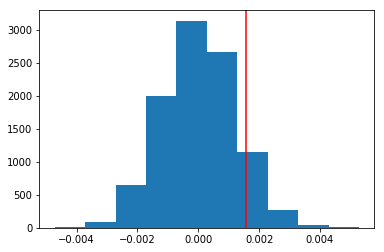

In [31]:
plt.hist(p_diffs)
plt.axvline(x = real_diff, color='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [47]:
#use real_diff obtained in Part I probability question 4(c) and 4(b)
(p_diffs>real_diff).mean()

0.097900000000000001

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The answer in part **j.** is p-value, which is the probability of observed data or some extreme case happen of alternatives, provided that null hypothesis is true.Usually, we will set a confidence interval of whether accept or reject the null hypothesis. If the p-value is less than Type I error threshold(5%), then we will have evidence to reject the null and choose the alternative. For above case, p-value = 0.0979 is greater than 0.05 so we fail to reject the null hypoesis, which means we there is no difference of old page and new page in terms of the converted rate.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
from scipy.stats import norm
convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group =="control"').shape[0]
n_new = df2.query('group =="treatment"').shape[0]


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [50]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
#z_score = 1.3109241984234394, p_value = 0.18988337448195103
norm.cdf(z_score) 
# 0.90505831275902449 # Tells us how significant our z-score is
norm.ppf(1-(0.05/2)), norm.cdf(z_score), z_score, p_value
# 1.959963984540054 # Tells us what our critical values at 95% confidence is

(1.959963984540054,
 0.90505831275902449,
 1.3109241984234394,
 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Our Conclusion

Since the z-score of 1.3109241984234394 within the critical value of 1.959963984540054, we fail to reject the null hypothesis that the difference between the two proportions is no different from zero. Since they are no different, , old Landing page 1 (17489/145274) is statistically equal to new landing page 2 (17264/145310). We would expect their long-term performance to be different from one another.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression  

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:

df2['intercept'] = 1
df2[['control','ab_page']] = pd.get_dummies(df2['group'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [37]:
df2.drop(['control'], axis=1, inplace=True)


In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
lm = sm.Logit(df2.converted, df2[['intercept','ab_page']])
result = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:22:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

P-value is 0.19, which means we fail to reject the null hypothesis. The null hypothesis is that there is no relationship between the converted rate and ab_page. It mean no matter which page the user received, the converted is not affected.

In part II, we assumed the null hypothesis that there is the converted rate for both pages are the same or old page has higher converted rate than new page. The p-value is 0.0965. We also have done the z-test in part II, which p-value is 0.189, similar to the one we get above. This is due to the directionality component of the tests. we have performed the one-tailed test and 2-tailed z-test(alternative hyposthese). As you can see, the p-value in one-tailed test is almost half of the 2 tailed test.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors like visting time(daytime or night time), where the users are. For example, maybe the converted rate in night time is greater than in day time because most of the users are busy during daytime. Another example is that people in China, they used to see lots of pop up ad. or can process lots of info. from the web page. That's why Amazon made a customized web version for them.

It would be a good idea to add these factors to the regression model in order to make a better prediction. However, it may lead to some troubles. The relationship is not liner or the data are correlated.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together the datasets on the approporiate rows.

In [41]:
c = pd.read_csv('countries.csv')
df3 = df2.merge(c, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


##### Now, we need to set 3 dummary variables for logistic regression.

In [42]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3.country)
df3

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


#### Apply logistic regression and fit the model

In [43]:
country_lm = sm.Logit(df3.converted, df3[['intercept','ab_page','US','UK']])
country_result = country_lm.fit()
country_result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        20:22:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [44]:
US_coeff = 0.0408
UK_coeff = 0.0506
np.exp(US_coeff), np.exp(UK_coeff)

(1.0416437559600236, 1.0519020483004984)

Canada is the baseline for logistic regression.
For every unit for ab_page decrease, convert will be 1.5% more likely to happen, holding all other varible constant.
For every unit for UK increases, convert is 5.2% more likely to happen, holding all other varible constant.
For every unit for US increases, convert is 4.2% more likely to happen, holding all other varible constant

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [45]:
df3['US_con'] = df3['ab_page']*df3['US']
df3['UK_con'] = df3['ab_page']*df3['UK']
df3['CA_con'] = df3['ab_page']*df3['CA']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_con,UK_con,CA_con
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [46]:
interact_lm = sm.Logit(df3.converted, df3[['intercept','ab_page','US','US_con','UK','UK_con']])
interact_result = interact_lm.fit()
interact_result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 28 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        20:22:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0175      0.038      0.465      0.642      -0.056       0.091
US_con         0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
UK_con         0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

As you can see, the p-value for US_con and UK_con are even higher. It means they are very unlikely to have interaction with the ab_page. Only the intercept has p-value less than 0.05 / 5%.

Conclusion:
As the done the Hypothese tests, which shows that there is no significamt statictally impact on conversion rate by new page. Even there is statically different for different country's user on conversion rate, the practical impact is small. So we would not recommend to use the new page. 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])